**Part 0: Abstract**

By unveiling the latent variables that can generate observed properties of objects is one of the most fundamental issues in unsupervised learning. However, one of the crucial problems of unsupervised learning algorithms is to detect the latent structure. In K-means problem for example, we need to determine the number of clusters. One classic way is by performing model selection, while the other way is to use a Bayesian nonparametric method. One important method of Bayesian nonparametric method is the Indian buffet process (IBP), which is a stochastic process that provides a probability distribution over equivalence classes of binary matrices of bounded rows and potentially infinite columns. 

In this report, we first implement the Indian buffet process by Gibbs sampling and Metropolis-Hasting algorithm in python. For improvement in efficiency, we perform matrix calculation optimization indicated from Griffiths&Ghahramani's complete paper[1] and utilize parallel programming, JIT and Cython to decrease the computation duration. Moreover, we use check the validity and effectiveness of our acceleration and optimization.

In [154]:
import math
import numpy as np
import time
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

**Part I: Data Simulation**

To implement the example in the paper before optimization, we have followed the quotation below from the original paper to generate data. 

"As a first demonstration of the ability of this algorithm to recover the latent structure responsible
for having generated observed data, we applied the Gibbs sampler for the infinite linear-Gaussian
model to a simulated data set consisting of 100 6×6 images, each generated by randomly assigning
a feature to each image to a class with probability 0.5, and taking a linear combination of the
weights associated with features to which the images were assigned (a similar data set was used by
Ghahramani, 1995).  The non-zero elements of A were all equal to 1.0, and σX was set to
0.5, introducing a large amount of noise. The data were generated from a model with K+ = 4 "

The "A" is constructed based on the example in a more complete paper by the same authors we find called "The Indian Buffet Process: An Introduction and Review" (Griffiths&Ghahramani, 2011). We have used this as a supplement to the given paper for enhancing our understanding of IBP. We have also used a trick in calculating the inverse as described in the paper when we imlement IBP later in this report.

In [155]:
np.random.seed(123)
N = 100 
K_plus = 4 
D = 36 
sigmaX = 0.5

# Simulated data based on the example in the paper
A = np.array(( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, \
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,1, 1, 1,0, 0, 0,  1, 0, 1, 0, 0, 0, 1, 1, 1,    \
             1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0,0, 0, 0, 0, 0,0 ,0, 0, \
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,0, 0, 0, 0,1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)).reshape(4, D)

Z_zero = np.zeros((N, K_plus))
X = np.zeros((N, D))
I = np.identity(D) * sigmaX

for i in range(N):
    Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    while (np.sum(Z_zero[i,:]) == 0):
        Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    X[i,:] = np.random.normal(0,1, (1,D)).dot(I)+Z_zero[i,:].dot(A)


**Part II: Defining original IBP**

<img src="IBPfigure6.png">

Indian restaurants in London offer buffets with an apparently infinite number of dishes. Indian buffet process (IBP) is a distribution over infinite binary matrices, specifying how customers (objects) choose dishes (features).

N customers enter a restaurant one after another. Each customer is exposed to a buffet consisting of infinitely many dishes arranged in a line. The first customer starts at the left of the buffet and takes a serving from each dish, stopping after certain number of dishes which follows a Poisson($\alpha$) distribution. The ith customer moves along the buffet, sampling dishes based on their ”popularity”. The ith customer takes dish k with probability $m_k$ , where $m_k$ is the number of previous customers who have sampled that dish. Having reached the end of all previous sampled dishes, the ith customer then tries a Poisson($\frac{\alpha}{i}$) number of new dishes.

 In conclusion, as the "Figure 6" above quoted from the original paper, except for the first customer(object), all the following customers(objects)’s choice can be divided into two parts. The first part depends on all the previous information and can be treated as Bernoulli trials, while the second part goes beyond the number of dishes from before and the number of ”new dishes” follows a Poisson distribution with a new rate of $\frac{\alpha}{i}$.

We can indicate which customers chose which dishes using a binary matrix Z with N rows and infinitely many columns, where $z_{ik}$ = 1 if the ith customer sampled the $k^{th}$ dish.

In [156]:
#prior of IBP
def IBP_prior(alpha, N):
    res = np.zeros((N, 1000))

    #First person
    temp = np.random.poisson(alpha)
    if temp > 0:
        res[0,0:temp] = np.ones(temp)

    #the rest with Bernoulli + Poisson
    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
    #sample as Bernoulli with rate m_k/i
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
    #The "untouched" dishes are got from poisson distribution with rate alpha/i
        temp = np.random.poisson(alpha/(i+1))
    #None zero
        if temp > 0:
    #The "new dishes", silimar logic as the very first person
            res[i, K_plus : K_plus + temp] = np.ones(temp)
    #length of new person's first few "bernoulli" choice 
            K_plus = K_plus + temp
    
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

**Part III: Defining original likelihood and likelihood with new inverse calculation method**
**("log_p" and "log_p_new")**

In the finite model, the D-dimensional vector of properties of an object i, $x_i$ is generated from a Gaussian distribution with mean $z_i$A and covariance matrix $\sum$X = $\sigma$^2_X I, where $z_i$ is a K-dimensional binary vector, and A is a K $\times$ D matrix of weights. In matrix notation, E[X] = ZA. If Z is a feature matrix, this is a form of binary factor analysis. The distribution of X given Z, A, and σ X is matrix Gaussian with mean ZA and covariance matrix $\sigma$^2_X I, where I is the identity matrix. The prior on A is also matrix Gaussian, with mean 0 and covariance matrix $\sigma$^2_X I. Integrating out A, we have:

$P(X|Z,\sigma_X, \sigma_A) = \frac{1}{(2 \pi)^{ND/2} (\sigma_X)^{(N-K)D}(\sigma_A)^{KD}(|Z^TZ+\frac{\sigma_X^2}{\sigma_A^2}I|)^{D/2}}\\exp\{-\frac{1}{2\sigma_X^2}tr(X^T(I-Z(Z^TZ+\frac{\sigma_X^2}{\sigma_A^2}I)^{-1}Z^T)X)\}$

Based on these information from the paper, we simply implemented the likelihood function as below.

In [157]:
# define a log likelihood function 
def log_p(X, Z, sigmaX, sigmaA, K, D, N):
    M = Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K)
    return (-1)*np.log(2*np.pi)*N*D*.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D - .5*D*np.log(np.linalg.det(M)) \
        -.5/(sigmaX**2)*np.trace( (X.T.dot( np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)) )).dot(X) )

Inspired by the formulas (23) and (24) in Griffiths and Ghahramani's[1] paper, we also tried to use the method to calculate inverse as below:

(latex needed for the two formulas)

In [158]:
def calcInverse(Z,M,i,k,val):
    """New inverse calculation as described in Griffiths and Ghahramani(2011)"""
    M_i = M - M.dot(Z[i,:].T.dot(Z[i,:].dot(M)))/(Z[i,:].dot(M.dot(Z[i,:].T))-1)
    Z[i,k] = val
    M = M_i - M_i.dot(Z[i,:].T.dot(Z[i,:].dot(M_i)))/(Z[i,:].dot(M_i.dot(Z[i,:].T))+1)
    Inv = M
    return Inv

In [159]:
#check whether the inversion method described by Griffiths and Ghahramani(2005) works
i=10
k=3
Z,K = IBP_prior(1,N)
M = np.linalg.inv(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))
Z[i,k] = 1
val = 0
loops = 1000
tcalcInv=np.zeros(loops)
for l in range(loops):
    inv1 = calcInverse(Z,M,i,k,val)


In [160]:
inv1

array([[ 0.04575105, -0.01429164,  0.00762023, -0.018591  ],
       [-0.01429164,  0.01612999, -0.01274981, -0.00391389],
       [ 0.00762023, -0.01274981,  0.12159758,  0.00554468],
       [-0.018591  , -0.00391389,  0.00554468,  0.18232224]])

In [161]:
np.linalg.inv(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))

array([[ 0.04575105, -0.01429164,  0.00762023, -0.018591  ],
       [-0.01429164,  0.01612999, -0.01274981, -0.00391389],
       [ 0.00762023, -0.01274981,  0.12159758,  0.00554468],
       [-0.018591  , -0.00391389,  0.00554468,  0.18232224]])

In [205]:
# define a log likelihood function using the new Inverse calculation method
def log_p_new(X, Z, sigmaX, sigmaA, K, D, N):
    i=7
    k=0
    Z,K = IBP_prior(1.0,X.shape[0])
    M = np.linalg.inv(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))
    Z[i,k] = 1
    val = 1
    loops = 1000
    for l in range(loops):
        inv1 = calcInverse(Z,M,i,k,val)

    return (-1)*np.log(2*np.pi)*N*D*.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D - .5*D*np.log(np.linalg.det(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))) \
        -.5/(sigmaX**2)*np.trace( (X.T.dot( np.identity(N)-Z.dot(inv1.dot(Z.T)) )).dot(X) )

In [206]:
alpha = 1
sigmaA =0.5
Z, Kplus = IBP_prior(alpha, N)
%timeit log_p(X, Z, sigmaX, sigmaA, Kplus , D, N)
%timeit log_p_new(X, Z, sigmaX, sigmaA, Kplus , D, N)

1000 loops, best of 3: 201 µs per loop


IndexError: index 0 is out of bounds for axis 1 with size 0

**Part IV: Defining original sampler function and with both likelihood calculation functions**

The functions below "sampler" and "sampler_new" are based on the derivitions shown in the paper. Since we are updating quite a few variables and they need each other to get updated, we put the MCMC in a complete function. Before every update, there is a comment to separate for readability. (Pleae not the "#M-H algorithm for XX" and "#update XXX")

The code is quite straightforward despite of the length since it is a direct implementation of Gibbs and Metropolis-Hasting. The theoretical analysis of every updating parts are describes below:

(Latex)

The full (posterior) conditional distribution is
P(zik|X,Z−i,k,σX,σA) ∝ P(X|Z−i,k,σX,σA)P(zik|z−i,k) (6)
When initializing the Gibbs sampler, set σA = 1,σX = 1,α ∼ Ga(1,1). Then the sampler does the following steps: (K in my code is denoted as K+, to differentiate it from the true value.)
1. Generate P(zik|X,Z−i,k,σX,σA) using the full conditional distribution (a) Remove singular features (at most one object has it);
decrease K+ by 1 for each feature removed (b) Determine each zik to be 0 or 1 by Metropolis
(c) Add new features from Pois(α) i
2. Sample σX∗ = σX + ε, where ε ∼ Unif(−0.05, 0.05), and accept σX∗ by Metropolis
3. Sample σA∗ = σA + ε, where ε ∼ Unif(−0.05, 0.05), and accept σA∗ by Metropolis
4. Generate α|Z ∼ Ga(1 + K+, 1 + 􏰀Ni=1 Hi), where K+ is the number of features with mk > 0
The Metropolis part for σA is demonstrated as follows (similar case for σX): • Genenerate a candidate value σA∗ = σA + ε, with ε ∼ Unif(−0.05, 0.05) • Generate a random number r ∼ Unif(0, 1)
• Accept σA∗ if r < min{1, P (σA∗ |Z, X, σX ) }, where σA is the current value P(σA|Z,X,σX)
The candidate value σA∗ is always accepted when the likelihood ratio P (σA∗ |Z, X, σX ) is larger than 1, P(σA|Z,X,σX)
i.e. P (σA∗ |Z, X, σX ) > P (σA|Z, X, σX ). Nevertheless, when the likelihood ratio is less than 1, there is still a non-zero probability to accept σA∗ , so the sampler can ”move forward”. Note that in my code, the log likelihoods are used in the following way:
min{1, P(σA∗ |Z,X,σX)} = exp(min{0,log(P(σA∗ |Z,X,σX)) − log(P(σA|Z,X,σX))}) (7)
Finally, the posterior expectation of A is:
E(A|X,Z)=(ZZ+σA2I) ZX (8)
This is denoted as Ainf, with size D × K+, and Ainf is the matrix of latent features (images) my code converges to. For the ith image, replace Z with only the ith row zi, and the resulting Ainf,i is the corresponding reversed image string (a linear combination of the K+ bases).

In [215]:
def sampler(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew):

#initialization
    count=0
    final_Z=np.zeros((niter,N,20))
    final_K=np.zeros((niter,1))
    final_sigma_X=np.zeros((niter,1))
    final_sigma_A=np.zeros((niter,1))
    final_alpha=np.zeros((niter,1))
    Z, Kplus = IBP_prior(alpha, N)
    
#repeat "nither" number of times
    for j in range(niter):
        final_Z[count,:,0:Kplus] = Z
        final_K[count] = Kplus
        final_sigma_X[count] = sigmaX
        final_sigma_A[count] = sigmaA
        final_alpha[count] = alpha
        count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           

           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  

            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )


        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        

        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

In [216]:
def sampler_new(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew):
    count=0
    final_Z=np.zeros((niter,N,20))
    final_K=np.zeros((niter,1))
    final_sigma_X=np.zeros((niter,1))
    final_sigma_A=np.zeros((niter,1))
    final_alpha=np.zeros((niter,1))
    Z, Kplus = IBP_prior(alpha, N)
   
    for j in range(niter):
        final_Z[count,:,0:Kplus] = Z
        final_K[count] = Kplus
        final_sigma_X[count] = sigmaX
        final_sigma_A[count] = sigmaA
        final_alpha[count] = alpha
        count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           
           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = log_p_new(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = log_p_new(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  
            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = log_p_new(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = log_p_new(X, Z, sigmaX, sigmaA, Kplus, D, N )

        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = log_p_new(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = log_p_new(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        
        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

**Part V: Algorithm implementation**

Before conducting optimization, we first test whether the code above works and give up a desired result similar to that in the paper. This is tested by checking the traceplot of certain variable and drawing the picture based from "A", which is the same as that in the paper. 

As is set in the paper: "The Gibbs sampler was initialized with K+ = 1, choosing the feature assignments for the first column by setting $z_i1$ = 1 with probability 0.5. $\sigma_A$, $\sigma_X$ , and $\alpha$ were initially set to 0.5, 1.7, and 1 respectively". To get a trace plot, parameters $\alpha$, $\sigma_A$ and $\sigma_X$ are sampled over 1000 iterations with 200 burn-in.

In [166]:
%%time
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN

chain_Z, chain_K, chain_sigma_A, chain_sigma_X, chain_alpha, Z= sampler(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew)

CPU times: user 12min 1s, sys: 6.55 s, total: 12min 7s
Wall time: 6min 12s


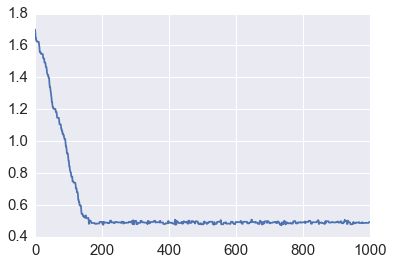

In [167]:
import matplotlib.pyplot as plt
plt.plot(chain_sigma_X)

In [172]:
XRecreated=np.zeros((N,D))
Z=Z[:,0:4]
sigma_X=np.mean(chain_sigma_X[BURN_IN:niter])
sigma_A=np.mean(chain_sigma_A[BURN_IN:niter])
A_inf=np.dot(np.dot(np.linalg.inv((np.dot(Z.T,Z)+(sigmaX/sigmaA)*np.eye(4))),Z.T),X)

for i in range(N):
    XRecreated[i,:]=np.dot(Z_final[i,:],A_inf[0:4,])

(From Dipesh's)

Posterior estimation of A is given by:
E[A|X,Z]=(ZZ+σA2I) ZX
as given in Griffiths and Ghahramani(2005) [2] eq.59. For this calculation, we used the final Z obtained from the MC with only the first four columns corresponding to the four detected features. Likewise, posterior means of σX and σA were used in the calculation of posterior estimation of weight matrix A.

With this information and the posterior Z, we were able to recreate the objects X as: xi ∼Normal(ziA,0)
We used zero variance to ignore the white noise in the recreated images. The results are shown in Fig. 4. By comparing with the original features and simulated objects as given in Fig. 3 with the detected features and recreated objects as given in Fig. 4, we can conclude that the algorithm was successfull in identifying all the latent features and successfully detecting the presense or absence of those features in the simulated objects which had white noise making detection difficult.

100 images were generated as binary linear combinations of four sets of
class weights, shown in the images on the top. The images on the bottom are the posterior
mean weights A for a single sample of Z after 200 iterations, ordered to match the true
classes. 

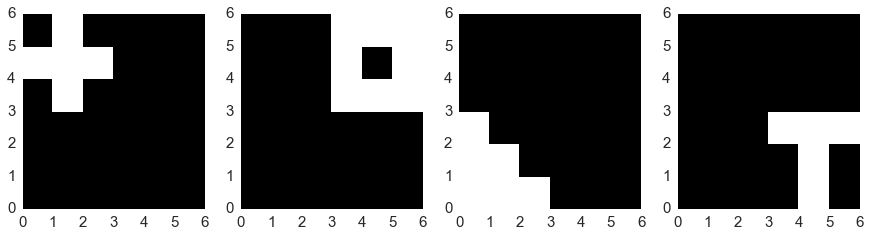

In [173]:
#Initial plots
plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A[3,:].reshape(6,6),cmap=plt.cm.gray) 

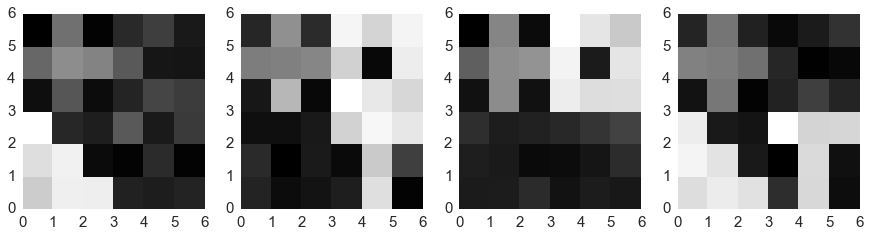

In [228]:

plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(XRecreated[1,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(142)
plt.pcolormesh(XRecreated[2,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(143)
plt.pcolormesh(XRecreated[3,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(144)
plt.pcolormesh(XRecreated[98,:].reshape(6,6),cmap=plt.cm.gray)

From left to right: 0010, 0101, 1100, 1011


Moreover, the latent feature model is able to ”reverse” the noisy images to the linear combination of latent features. Figure 7 is an example of the first four images in the simulated dataset: The top row contains the ”reversed” images, and the latent features in each one can be clearly seen. The bottom row represents the original images, in which the latent features are obscured by the random noise. The binary strings on top of all images indicate which bases are present in which image; for example, the string ”1100” represents an image as a linear combination of the first and second bases, without the third and fourth ones.

Detected Features, First four recreated objects and the features present in each of the objects. First row shows the 4 latent features used detected by MCMC. Second row shows the first four recreated objects. Light signifies presence and dark signifies the absence of the feature for any given object.


**Part VI: Optimization**

**Option1: Concurrent Parallization**

In [180]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [181]:
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN

In [182]:
%%time
# from sampler_origin import sampler_original
start = time.clock()
final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z= sampler(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew)
end1 = time.clock() - start

CPU times: user 10min 36s, sys: 5.91 s, total: 10min 42s
Wall time: 5min 30s


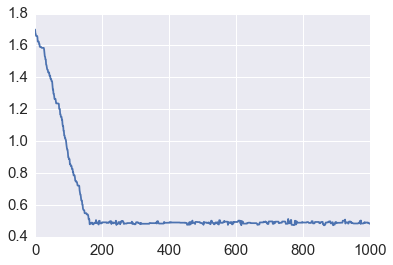

In [183]:
import matplotlib.pyplot as plt
plt.plot(final_sigma_X)

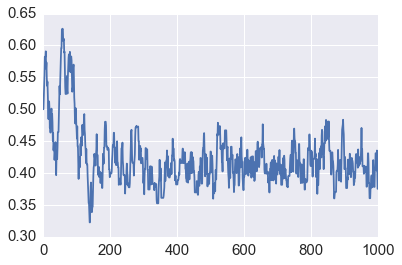

In [184]:
plt.plot(final_sigma_A)

In [185]:
%%time
# from sampler_origin import sampler_original
start = time.clock()
with ProcessPoolExecutor(max_workers=8) as pool:
    res = pool.submit(sampler, X, niter, sigmaX, sigmaA,alpha, N, D, maxNew)
end2 = time.clock() - start

CPU times: user 49.2 ms, sys: 171 ms, total: 220 ms
Wall time: 5min 30s


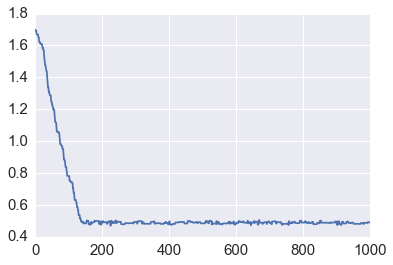

In [186]:
plt.plot(res.result()[3])

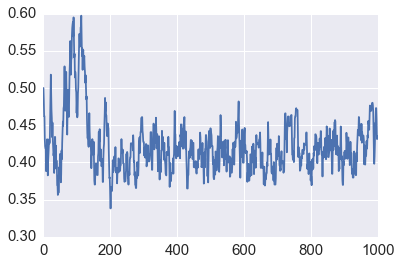

In [187]:
plt.plot(res.result()[2])

In [188]:
end1/end2

2920.7362687145965

**Conclusion: The trace plot are the same, by comparing the time, we can see that the ue parallel computing will dramatically improve efficiency.**

using sampler_new which contains log_p_new with a new way of calculating inverse

In [196]:
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN

In [197]:
%%time
# from sampler_origin import sampler_original
start = time.clock()
final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z= sampler_new(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew)
end1 = time.clock() - start

ValueError: shapes (7,7) and (6,100) not aligned: 7 (dim 1) != 6 (dim 0)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(final_sigma_X)

In [ ]:
plt.plot(final_sigma_A)

In [146]:
%%time
# from sampler_origin import sampler_original
start = time.clock()
with ProcessPoolExecutor(max_workers=8) as pool:
    res = pool.submit(sampler_new, X, niter, sigmaX, sigmaA,alpha, N, D, maxNew)
end2 = time.clock() - start

CPU times: user 12.4 ms, sys: 39.9 ms, total: 52.3 ms
Wall time: 9.57 s


In [ ]:
plt.plot(res.result()[3])

In [ ]:
plt.plot(res.result()[2])

In [ ]:
end1/end2

**Option2: JIT**

In [207]:
import numba
from numba import jit

In [208]:
@jit
def sampler_numba(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew):
    count=0
    final_Z=np.zeros((niter,N,20))
    final_K=np.zeros((niter,1))
    final_sigma_X=np.zeros((niter,1))
    final_sigma_A=np.zeros((niter,1))
    final_alpha=np.zeros((niter,1))
    Z, Kplus = IBP_prior(alpha, N)

    for j in range(niter):
        final_Z[count,:,0:Kplus] = Z
        final_K[count] = Kplus
        final_sigma_X[count] = sigmaX
        final_sigma_A[count] = sigmaA
        final_alpha[count] = alpha
        count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           
           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  
            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )

        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        
        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

In [214]:
%timeit sampler_numba(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew)

1 loops, best of 3: 5min 31s per loop


In [217]:
%timeit sampler(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew)

1 loops, best of 3: 5min 22s per loop


**Conclusion: There seems to be little difference between JIT version and the original version.**

**Option3: Cython**

**Part VII: Conclusions**

**References**

[1] Griffiths, Thomas L., and Zoubin Ghahramani. "The indian buffet process: An introduction and review." The Journal of Machine Learning Research 12 (2011): 1185-1224.

#### Using ipyparallel

In [255]:
from ipyparallel import Client
import time

In [206]:
#! ipcluster start -n 5

In [256]:
rc = Client()
print(rc.ids)
dv = rc[:]

[0, 1, 2, 3, 4]


//anaconda/lib/python3.5/site-packages/ipyparallel/client/client.py:436: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@10.190.51.211')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


IPyParallel+numba

In [291]:
with dv.sync_imports():
    import numba

importing numba on engine(s)


In [292]:
@numba.jit
def sampleIBP(alpha, N):
    res = np.zeros((N, 1000))
    temp = np.random.poisson(alpha)
    if temp>0:
        res[0,0:temp] = np.ones(temp)
    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
        temp = np.random.poisson(alpha/(i+1))
        if temp>0:
            res[i, K_plus:K_plus+temp] = np.ones(temp)
            K_plus = K_plus + temp
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

In [293]:
@numba.jit
def sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew):
    HN = 0.
    for i in range(1,N+1):
        HN += 1./i

    SAMPLE_SIZE=niter-BURN_IN

    K_inf=20

    chain_Z=np.zeros((SAMPLE_SIZE,N,K_inf))
    chain_K=np.zeros((SAMPLE_SIZE,1))
    chain_sigma_X=np.zeros((SAMPLE_SIZE,1))
    chain_sigma_A=np.zeros((SAMPLE_SIZE,1))
    chain_alpha=np.zeros((SAMPLE_SIZE,1))
    np.random.seed(1)
    Z, Kplus = sampleIBP(alpha, N)
    s_counter=0

    for j in range(niter):
        if((j+1)>BURN_IN):
            chain_Z[s_counter,:,0:Kplus]=Z
            chain_K[s_counter]=Kplus
            chain_sigma_X[s_counter]=sigmaX
            chain_sigma_A[s_counter]=sigmaA
            chain_alpha[s_counter]=alpha
            s_counter=s_counter+1

        for i in range(N):
            for k in range(Kplus):
                if k>=Kplus:
                    break     
                #Removing the singular features, i.e. the ones that have 1 for the current object only.
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <=0:
                        #Z[i,k] = 0
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus] #shift everything one column to the left
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus] # remove the last column as it is redundent
                        continue #We're no longer looking at this feature, so move to another one               

                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)

                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   

            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N
            for kNew in range(maxNew): # max new features is 3
                Z_temp = Z
                if kNew>0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                lik = ll(X = X, Z = Z_temp, sigmaX = sigmaX, sigmaA = sigmaA, K=(Kplus+kNew), D= D, N= N)
                prob[kNew] = pois + lik

            #normalize prob
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p+prob[new]
                if U<p:
                    kNew = new
                    break

            #Add kNew new columns to Z and set the values at ith row to 1 for all of them
            if kNew>0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 

        llCurrent = ll(X, Z, sigmaX, sigmaA, Kplus, D, N )
        #update sigmaX
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - np.random.uniform(0,1)/20
        else:
            sigmaX_new = sigmaX + np.random.uniform(0,1)/20
        llNew = ll(X, Z, sigmaX_new, sigmaA, Kplus, D, N)

        arX = np.exp(min(0,llNew-llCurrent))
        U = np.random.uniform(0,1)
        if U < arX:
            sigmaX = sigmaX_new

        #update sigma_A
        #epsA = np.random.uniform(0,1)
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - np.random.uniform(0,1)/20
        else:
            sigmaA_new = sigmaA + np.random.uniform(0,1)/20

    #     epsA = np.random.uniform(-.05,.05)
    #     sigmaA_new = sigmaA+epsA
        #llCurrent = ll(X, Z, sigmaX, sigmaA, Kplus, D, N )
        #llCurrent = ll(X, Z, sigmaX, sigmaA, Kplus, D, N )
        llNew = ll(X, Z, sigmaX, sigmaA_new, Kplus, D, N)

        arA = np.exp(min(0,llNew-llCurrent))

        U = np.random.uniform(0,1)
        if U < arA:
            sigmaA = sigmaA_new
        alpha = np.random.gamma(1+Kplus, 1/(1+HN))   
    return(chain_Z, chain_K, chain_sigma_A, chain_sigma_X, chain_alpha, Z)

In [294]:
%%time
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN


chain_Z, chain_K, chain_sigma_A, chain_sigma_X, chain_alpha, Z= sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)

CPU times: user 13min 25s, sys: 8.72 s, total: 13min 34s
Wall time: 7min 11s


IPyParallel+Cython

In [285]:
%load_ext cython

In [286]:
%%cython -n cylib

import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def f(np.ndarray[np.float64_t, ndim=1] x):
    x.setflags(write=True)
    cdef int i
    cdef int n = x.shape[0]
    cdef double s = 0

    for i in range(n):
        s += x[i]
    return s

In [287]:
import site
import shutil
src = glob.glob(os.path.join(os.path.expanduser('~/'), '.ipython', 'cython', 'cylib*so'))[0]
dst = site.getsitepackages()[0]
shutil.copy(src, dst)

'//anaconda/lib/python3.5/site-packages/cylib.cpython-35m-darwin.so'

In [288]:
with dv.sync_imports():
    import cylib

importing cylib on engine(s)


In [290]:
%%time
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN

chain_Z, chain_K, chain_sigma_A, chain_sigma_X, chain_alpha, Z= cylib.sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)

AttributeError: module 'cylib' has no attribute 'sampler'

In [301]:
%%cython -a
import numpy as np
import scipy as sp
import math
def sampleIBP(alpha, N):
    res = np.zeros((N, 1000))
    temp = np.random.poisson(alpha)
    if temp>0:
        res[0,0:temp] = np.ones(temp)
    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
        temp = np.random.poisson(alpha/(i+1))
        if temp>0:
            res[i, K_plus:K_plus+temp] = np.ones(temp)
            K_plus = K_plus + temp
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

#log likelihood function 
def ll(X, Z, sigmaX, sigmaA, K, D, N):
    M = Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K)
    return ((-1)*np.log(2*np.pi)*N*D*0.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D-0.5*D*np.log(np.linalg.det(M))-.5/(sigmaX**2)*np.trace((X.T.dot(np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)))).dot(X)))

def sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew):
    HN = 0.
    for i in range(1,N+1):
        HN += 1./i

    SAMPLE_SIZE=niter-BURN_IN

    K_inf=20

    chain_Z=np.zeros((SAMPLE_SIZE,N,K_inf))
    chain_K=np.zeros((SAMPLE_SIZE,1))
    chain_sigma_X=np.zeros((SAMPLE_SIZE,1))
    chain_sigma_A=np.zeros((SAMPLE_SIZE,1))
    chain_alpha=np.zeros((SAMPLE_SIZE,1))
    np.random.seed(1)
    Z, Kplus = sampleIBP(alpha, N)
    s_counter=0

    for j in range(niter):
        if((j+1)>BURN_IN):
            chain_Z[s_counter,:,0:Kplus]=Z
            chain_K[s_counter]=Kplus
            chain_sigma_X[s_counter]=sigmaX
            chain_sigma_A[s_counter]=sigmaA
            chain_alpha[s_counter]=alpha
            s_counter=s_counter+1

        for i in range(N):
            for k in range(Kplus):
                if k>=Kplus:
                    break     
                #Removing the singular features, i.e. the ones that have 1 for the current object only.
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <=0:
                        #Z[i,k] = 0
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus] #shift everything one column to the left
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus] # remove the last column as it is redundent
                        continue #We're no longer looking at this feature, so move to another one               

                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = ll(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)

                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = ll(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   

            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N
            for kNew in range(maxNew): # max new features is 3
                Z_temp = Z
                if kNew>0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                lik = ll(X = X, Z = Z_temp, sigmaX = sigmaX, sigmaA = sigmaA, K=(Kplus+kNew), D= D, N= N)
                prob[kNew] = pois + lik

            #normalize prob
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p+prob[new]
                if U<p:
                    kNew = new
                    break

            #Add kNew new columns to Z and set the values at ith row to 1 for all of them
            if kNew>0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 

        llCurrent = ll(X, Z, sigmaX, sigmaA, Kplus, D, N )
        #update sigmaX
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - np.random.uniform(0,1)/20
        else:
            sigmaX_new = sigmaX + np.random.uniform(0,1)/20
        llNew = ll(X, Z, sigmaX_new, sigmaA, Kplus, D, N)

        arX = np.exp(min(0,llNew-llCurrent))
        U = np.random.uniform(0,1)
        if U < arX:
            sigmaX = sigmaX_new

        #update sigma_A
        #epsA = np.random.uniform(0,1)
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - np.random.uniform(0,1)/20
        else:
            sigmaA_new = sigmaA + np.random.uniform(0,1)/20

    #     epsA = np.random.uniform(-.05,.05)
    #     sigmaA_new = sigmaA+epsA
        #llCurrent = ll(X, Z, sigmaX, sigmaA, Kplus, D, N )
        #llCurrent = ll(X, Z, sigmaX, sigmaA, Kplus, D, N )
        llNew = ll(X, Z, sigmaX, sigmaA_new, Kplus, D, N)

        arA = np.exp(min(0,llNew-llCurrent))

        U = np.random.uniform(0,1)
        if U < arA:
            sigmaA = sigmaA_new
        alpha = np.random.gamma(1+Kplus, 1/(1+HN))   
    return(chain_Z, chain_K, chain_sigma_A, chain_sigma_X, chain_alpha, Z)